# Techniques for Handling Imbalanced Classification

In many real-world machine learning problems, the dataset is **imbalanced**, meaning one class has many more samples than the other.  
For example, in fraud detection or medical diagnosis, the positive class (fraud or disease) is much rarer than the negative class.

This imbalance can cause machine learning models to perform poorly on the minority class, since the model tends to focus on the majority class.

In this notebook, we will explore four simple and widely used techniques to handle class imbalance:

1. **Random Oversampling**  
2. **SMOTE (Synthetic Minority Oversampling Technique)**  
3. **Random Undersampling**  
4. **Class Weights / Loss Function based adjustment**

We will use a synthetic imbalanced dataset to demonstrate these methods.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Generate imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=1,
                           weights=[0.9, 0.1],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=10, n_clusters_per_class=1,
                           n_samples=1000, random_state=42)

print('Class distribution:', np.bincount(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)

Class distribution: [900 100]


## 1. Baseline Model (No Imbalance Handling)

Let's first train a logistic regression model **without** handling class imbalance to see how it performs.


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       270
           1       0.80      0.67      0.73        30

    accuracy                           0.95       300
   macro avg       0.88      0.82      0.85       300
weighted avg       0.95      0.95      0.95       300



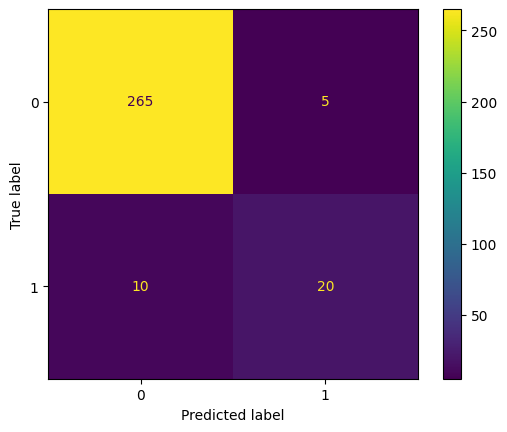

In [2]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

## 2. Random Oversampling

Random oversampling increases the number of samples in the minority class by **randomly duplicating** them until both classes are balanced.

This is simple but can lead to overfitting since it duplicates the same information multiple times.

We will use `imblearn` library to implement this method.

Use `pip install imblearn` to install the library.


Resampled class distribution: [630 630]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       270
           1       0.61      0.93      0.74        30

    accuracy                           0.93       300
   macro avg       0.80      0.93      0.85       300
weighted avg       0.95      0.93      0.94       300



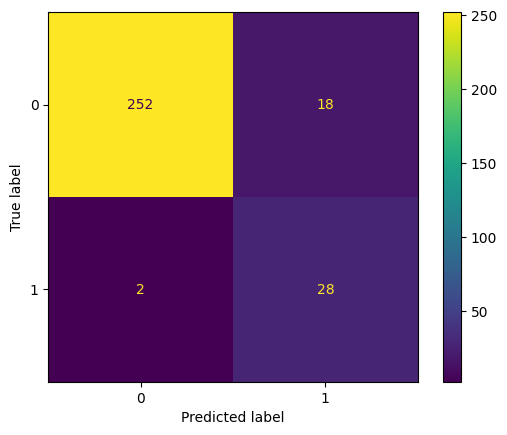

In [3]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled class distribution:', np.bincount(y_res))

clf_over = LogisticRegression()
clf_over.fit(X_res, y_res)
y_pred_over = clf_over.predict(X_test)

print(classification_report(y_test, y_pred_over))
ConfusionMatrixDisplay.from_estimator(clf_over, X_test, y_test)
plt.show()

## 3. SMOTE (Synthetic Minority Oversampling Technique)

Unlike random oversampling, **SMOTE** generates *new synthetic samples* instead of simply duplicating existing ones.

### How SMOTE Works (Mathematical Explanation)

For each minority class sample $x_i$:

1. Choose one of its *k-nearest neighbors* (say $x_{nn}$).
2. Generate a new synthetic sample $x_{new}$ as:

$$ x_{new} = x_i + \delta (x_{nn} - x_i) $$

where $\delta \sim U(0,1)$ is a random number between 0 and 1.

This interpolation creates more **diverse synthetic samples**, which helps reduce overfitting compared to random oversampling.


Resampled class distribution (SMOTE): [630 630]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       270
           1       0.61      0.93      0.74        30

    accuracy                           0.93       300
   macro avg       0.80      0.93      0.85       300
weighted avg       0.95      0.93      0.94       300



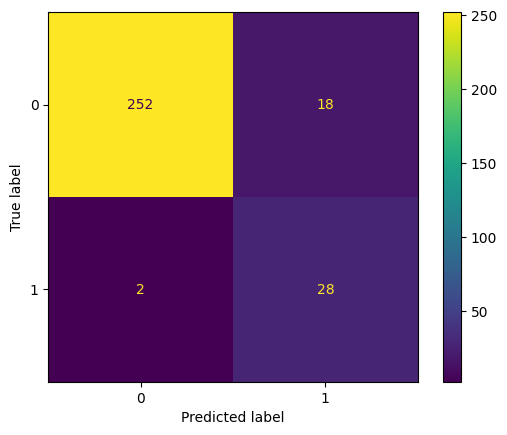

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Resampled class distribution (SMOTE):', np.bincount(y_res))

clf_smote = LogisticRegression()
clf_smote.fit(X_res, y_res)
y_pred_smote = clf_smote.predict(X_test)

print(classification_report(y_test, y_pred_smote))
ConfusionMatrixDisplay.from_estimator(clf_smote, X_test, y_test)
plt.show()

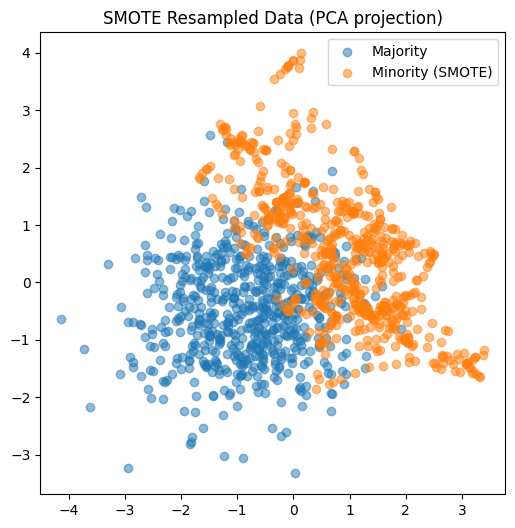

In [5]:
# Visualization of synthetic samples (PCA projection)
pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(X_res)

plt.figure(figsize=(6,6))
plt.scatter(X_vis[y_res==0, 0], X_vis[y_res==0, 1], alpha=0.5, label='Majority')
plt.scatter(X_vis[y_res==1, 0], X_vis[y_res==1, 1], alpha=0.5, label='Minority (SMOTE)')
plt.legend()
plt.title("SMOTE Resampled Data (PCA projection)")
plt.show()

## 4. Random Undersampling

Random undersampling balances the dataset by **removing samples from the majority class**.

This reduces dataset size and training time, but risks losing useful information from the majority class.


Resampled class distribution: [70 70]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       270
           1       0.58      0.93      0.72        30

    accuracy                           0.93       300
   macro avg       0.79      0.93      0.84       300
weighted avg       0.95      0.93      0.93       300



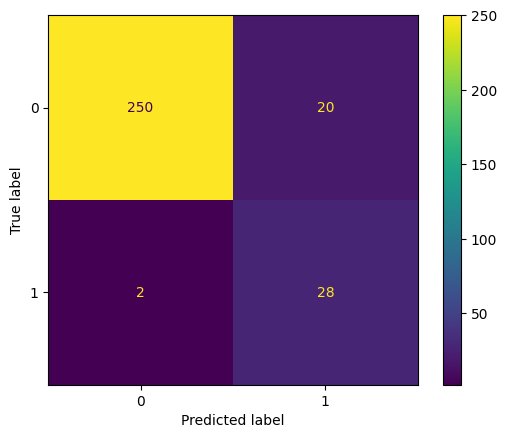

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled class distribution:', np.bincount(y_res))

clf_under = LogisticRegression()
clf_under.fit(X_res, y_res)
y_pred_under = clf_under.predict(X_test)

print(classification_report(y_test, y_pred_under))
ConfusionMatrixDisplay.from_estimator(clf_under, X_test, y_test)
plt.show()

## 5. Class Weights / Loss Function Adjustment

Many algorithms allow us to assign **class weights**, so that misclassifying a minority class sample is penalized more.

In scikit-learn, we can use `class_weight='balanced'`.


              precision    recall  f1-score   support

           0       0.99      0.93      0.96       270
           1       0.60      0.93      0.73        30

    accuracy                           0.93       300
   macro avg       0.79      0.93      0.84       300
weighted avg       0.95      0.93      0.94       300



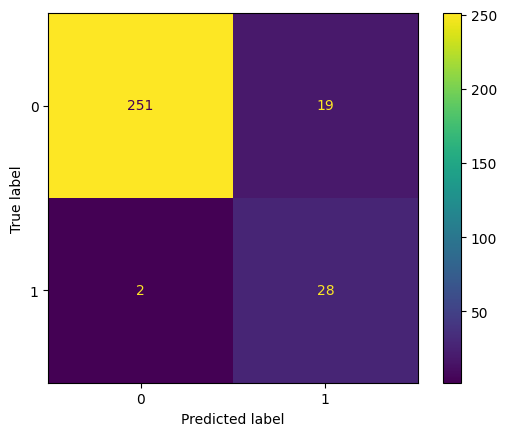

In [7]:
clf_weighted = LogisticRegression(class_weight='balanced', random_state=42)
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)

print(classification_report(y_test, y_pred_weighted))
ConfusionMatrixDisplay.from_estimator(clf_weighted, X_test, y_test)
plt.show()

# Conclusion

We explored four common methods to handle imbalanced data:

- **Random Oversampling**: Duplicates minority samples.  
- **SMOTE**: Synthesizes new samples using interpolation.  
- **Random Undersampling**: Removes samples from the majority class.  
- **Class Weights**: Adjusts algorithm to focus more on minority class.  

Each method has its pros and cons, and the best choice depends on the dataset and task.
